In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib
import os
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential
from IPython.display import Image
from keras import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras import datasets, layers, models, losses
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
dataset_dir = os.path.join(os.getcwd(), "CIFAKE")

img_height = 32
img_width = 32
batch_size = 256

# Load training and validation data
train, val = keras.utils.image_dataset_from_directory(
  os.path.join(dataset_dir, "train"),
  validation_split=0.2,
  subset="both",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 100000 files belonging to 2 classes.
Using 80000 files for training.
Using 20000 files for validation.


In [3]:
test = keras.utils.image_dataset_from_directory(
  os.path.join(dataset_dir, "test"),
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 20000 files belonging to 2 classes.


In [4]:
classes = train.class_names
classes

['FAKE', 'REAL']

In [5]:
input = layers.Input(shape=(32,32,3))
input_tensor = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=(32,32,3))(input)
# 7x7 convolution with stride 2 and 64 filters
x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_tensor)
# 3x3 max pooling with stride 2
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
# 1x1 convolution with 64 filters
x = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(x)
# 3x3 convolution with 192 filters
x = layers.Conv2D(192, (3, 3), padding='same', activation='relu')(x)
# 3x3 max pooling with stride 2
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
#inception 1
branch1 = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(96, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(branch2)
branch3 = layers.Conv2D(16, (1, 1), padding='same', activation='relu')(x)
branch3 = layers.Conv2D(32, (5, 5), padding='same', activation='relu')(branch3)
branch4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
branch4 = layers.Conv2D(32, (1, 1), padding='same', activation='relu')(branch4)
x = layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)
#inception 2
branch1 = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(192, (3, 3), padding='same', activation='relu')(branch2)
branch3 = layers.Conv2D(32, (1, 1), padding='same', activation='relu')(x)
branch3 = layers.Conv2D(96, (5, 5), padding='same', activation='relu')(branch3)
branch4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
branch4 = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(branch4)
x = layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
#inception 3
branch1 = layers.Conv2D(192, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(96, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(208, (3, 3), padding='same', activation='relu')(branch2)
branch3 = layers.Conv2D(16, (1, 1), padding='same', activation='relu')(x)
branch3 = layers.Conv2D(48, (5, 5), padding='same', activation='relu')(branch3)
branch4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
branch4 = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(branch4)
x = layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)
#auxiliary 1
auxx = layers.AveragePooling2D((5, 5), strides=(3, 3))(x)
auxx = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(auxx)
auxx = layers.Flatten()(auxx)
auxx = layers.Dense(1024, activation='relu')(auxx)
auxx = layers.Dropout(0.7)(auxx)
auxx = layers.Dense(1, activation='sigmoid', name="aux1")(auxx)
#inception 4
branch1 = layers.Conv2D(160, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(112, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(224, (3, 3), padding='same', activation='relu')(branch2)
branch3 = layers.Conv2D(24, (1, 1), padding='same', activation='relu')(x)
branch3 = layers.Conv2D(64, (5, 5), padding='same', activation='relu')(branch3)
branch4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
branch4 = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(branch4)
x = layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)
#inception 5
branch1 = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(branch2)
branch3 = layers.Conv2D(24, (1, 1), padding='same', activation='relu')(x)
branch3 = layers.Conv2D(64, (5, 5), padding='same', activation='relu')(branch3)
branch4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
branch4 = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(branch4)
x = layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)
#inception 6
branch1 = layers.Conv2D(112, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(144, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(288, (3, 3), padding='same', activation='relu')(branch2)
branch3 = layers.Conv2D(32, (1, 1), padding='same', activation='relu')(x)
branch3 = layers.Conv2D(64, (5, 5), padding='same', activation='relu')(branch3)
branch4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
branch4 = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(branch4)
x = layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)
#auxiliary 2
auxx2 = layers.AveragePooling2D((5, 5), strides=(3, 3))(x)
auxx2 = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(auxx2)
auxx2 = layers.Flatten()(auxx2)
auxx2 = layers.Dense(1024, activation='relu')(auxx2)
auxx2 = layers.Dropout(0.7)(auxx2)
auxx2 = layers.Dense(1, activation='sigmoid', name="aux2")(auxx2)
#inception 7
branch1 = layers.Conv2D(256, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(160, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(320, (3, 3), padding='same', activation='relu')(branch2)
branch3 = layers.Conv2D(32, (1, 1), padding='same', activation='relu')(x)
branch3 = layers.Conv2D(128, (5, 5), padding='same', activation='relu')(branch3)
branch4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
branch4 = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(branch4)
x = layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
#inception 8
branch1 = layers.Conv2D(256, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(160, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(320, (3, 3), padding='same', activation='relu')(branch2)
branch3 = layers.Conv2D(32, (1, 1), padding='same', activation='relu')(x)
branch3 = layers.Conv2D(128, (5, 5), padding='same', activation='relu')(branch3)
branch4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
branch4 = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(branch4)
x = layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)
#inception 9
branch1 = layers.Conv2D(384, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(192, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(384, (3, 3), padding='same', activation='relu')(branch2)
branch3 = layers.Conv2D(48, (1, 1), padding='same', activation='relu')(x)
branch3 = layers.Conv2D(128, (5, 5), padding='same', activation='relu')(branch3)
branch4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
branch4 = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(branch4)
x = layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)

x = layers.AveragePooling2D((7, 7), strides=(1, 1))(x)
x = layers.Dropout(0.4)(x)
x = layers.Flatten()(x)

output = layers.Dense(1, activation='sigmoid', name='output')(x)

model = keras.Model(input, [output, auxx, auxx2], name='inceptionnet')

In [6]:
model.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=[losses.binary_crossentropy, losses.binary_crossentropy, losses.binary_crossentropy],
              loss_weights=[1, 0.3, 0.3],
              metrics=["accuracy", metrics.Precision(name="precision"), metrics.Recall(name="recall")])

from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_output_accuracy', mode='max', patience=10,  restore_best_weights=True, verbose=1)
model.summary()

Model: "inceptionnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 resizing (Resizing)            (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['resizing[0][0]']               
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 56, 56, 64)   0           ['conv2d[0][0]']      

In [7]:
epochs = 80

history = model.fit(
  train,
  validation_data=val,
  epochs=epochs,
  verbose=0, callbacks=[es])

history = pd.DataFrame(history.history)
display(history)

Restoring model weights from the end of the best epoch: 28.
Epoch 38: early stopping


,loss,output_loss,aux1_loss,aux2_loss,output_accuracy,output_precision,output_recall,aux1_accuracy,aux1_precision,aux1_recall,...,val_aux2_loss,val_output_accuracy,val_output_precision,val_output_recall,val_aux1_accuracy,val_aux1_precision,val_aux1_recall,val_aux2_accuracy,val_aux2_precision,val_aux2_recall
0,0.628426,0.388728,0.404356,0.394639,0.815800,0.811033,0.823284,0.817712,0.810068,0.829861,...,0.248629,0.89940,0.893810,0.906840,0.88390,0.849333,0.933799,0.89830,0.887691,0.912332
1,0.388242,0.237114,0.261511,0.242252,0.901688,0.900199,0.903464,0.891325,0.886834,0.897036,...,0.190300,0.92275,0.907212,0.942087,0.91780,0.925745,0.908737,0.92535,0.922634,0.928807
2,0.316337,0.193011,0.214032,0.197056,0.922450,0.920863,0.924272,0.913863,0.910188,0.918269,...,0.211906,0.92300,0.899124,0.953170,0.89855,0.848004,0.971543,0.91435,0.875384,0.966550
3,0.280988,0.171179,0.192089,0.173942,0.933125,0.932106,0.934250,0.924300,0.921908,0.927073,...,0.170389,0.93235,0.901241,0.971343,0.93100,0.909669,0.957264,0.93075,0.899389,0.970245
4,0.254327,0.153843,0.177840,0.157107,0.939637,0.939296,0.939977,0.930037,0.927541,0.932900,...,0.210159,0.90935,0.858166,0.981128,0.91300,0.866248,0.977134,0.91860,0.877147,0.973839
5,0.218713,0.131014,0.156678,0.135650,0.948913,0.947561,0.950381,0.938800,0.937726,0.939977,...,0.139230,0.94885,0.959808,0.937094,0.94245,0.950956,0.933200,0.94665,0.960288,0.932002
6,0.207196,0.123694,0.148244,0.130096,0.951262,0.950624,0.951932,0.941700,0.940137,0.943429,...,0.143603,0.94625,0.956962,0.934698,0.94550,0.948177,0.942686,0.94375,0.960526,0.925711
7,0.195331,0.115970,0.142126,0.122413,0.954875,0.954199,0.955583,0.944225,0.943384,0.945129,...,0.138631,0.94895,0.962845,0.934099,0.94145,0.968531,0.912731,0.94705,0.964716,0.928208
8,0.184943,0.109305,0.136796,0.115331,0.957712,0.957411,0.958009,0.947237,0.946536,0.947980,...,0.116250,0.95750,0.956834,0.958362,0.95175,0.963817,0.938892,0.95540,0.962205,0.948178
9,0.161104,0.093007,0.124632,0.102355,0.964550,0.964049,0.965062,0.952050,0.951761,0.952332,...,0.119204,0.95250,0.938983,0.968048,0.94570,0.927184,0.967549,0.95530,0.949620,0.961757


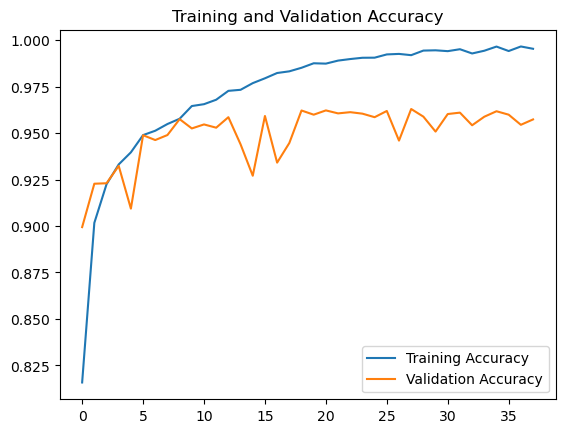

In [8]:
plt.plot(range(len(history)), history["output_accuracy"], label="Training Accuracy")
plt.plot(range(len(history)), history["val_output_accuracy"], label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")
plt.show()

In [9]:
model.evaluate(test, return_dict=True)

79/79 [==============================] - 7s 79ms/step - loss: 0.2533 - output_loss: 0.1732 - aux1_loss: 0.1135 - aux2_loss: 0.1536 - output_accuracy: 0.9611 - output_precision: 0.9637 - output_recall: 0.9584 - aux1_accuracy: 0.9590 - aux1_precision: 0.9528 - aux1_recall: 0.9660 - aux2_accuracy: 0.9601 - aux2_precision: 0.9647 - aux2_recall: 0.9551


{'loss': 0.2533390522003174,
 'output_loss': 0.17321805655956268,
 'aux1_loss': 0.11346250027418137,
 'aux2_loss': 0.1536073237657547,
 'output_accuracy': 0.9611499905586243,
 'output_precision': 0.9637003540992737,
 'output_recall': 0.9584000110626221,
 'aux1_accuracy': 0.9590499997138977,
 'aux1_precision': 0.9527567028999329,
 'aux1_recall': 0.9660000205039978,
 'aux2_accuracy': 0.960099995136261,
 'aux2_precision': 0.9647474884986877,
 'aux2_recall': 0.9550999999046326}

In [12]:
test_predictions = np.array([])
test_labels = np.array([])
for x, y in test:
    test_predictions = np.append(test_predictions, model(x) > 0.5)
    test_labels = np.append(test_labels, y)
ConfusionMatrixDisplay.from_predictions(test_labels, test_predictions, display_labels=classes, cmap="Blues");

8/8 [==============================] - 1s 48ms/step


TypeError: '>' not supported between instances of 'list' and 'float'

In [11]:
model.predict(test)

79/79 [==============================] - 6s 77ms/step


[array([[1.4224192e-06],
        [3.5888941e-05],
        [1.2204083e-13],
        ...,
        [9.9999917e-01],
        [1.0000000e+00],
        [2.7290446e-04]], dtype=float32),
 array([[4.27963072e-03],
        [4.21428978e-02],
        [4.59535130e-07],
        ...,
        [9.99858022e-01],
        [9.99989986e-01],
        [1.10641755e-01]], dtype=float32),
 array([[2.8663371e-05],
        [3.5067071e-04],
        [1.1060298e-11],
        ...,
        [9.9998617e-01],
        [1.0000000e+00],
        [1.3477466e-03]], dtype=float32)]

In [10]:
len(model.predict(test))

79/79 [==============================] - 7s 79ms/step


3